# Dataset 2: Model 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import neighbors
from sklearn import tree
from sklearn import linear_model
import graphviz
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv('data/dataset2.csv',index_col='country')
df.head()

,ssm,gini,ppp,spi,nat_p,max_ev_p
country,,,,,,
Austria,1.0,30.5,52558.0,86.76,26.00,3.795771
Belgium,1.0,28.1,47561.0,87.39,24.00,4.672967
Croatia,0.0,32.2,25264.0,79.60,5.80,0.107844
Cyprus,0.0,35.6,34504.0,82.85,3.71,3.723006
Denmark,1.0,28.5,50541.0,89.96,21.10,2.000000


## Split data 

Norway is an extreme outlier and will therefore not be considered part of the training data. It has an exceptionally high market share of EVs while only having a relatively small population.

In [2]:
df = df.drop('Norway',axis=0)
X = df.drop('max_ev_p',axis=1)
y = df['max_ev_p']

train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

## Unlabeled data

In [3]:
new_X = pd.DataFrame(columns=X.columns)
new_X = new_X.append(pd.Series([0,0,0,0,0],index=X.columns,name='zero'))
new_X = new_X.append(pd.Series([0,0,0,0,100],index=X.columns,name='worst'))
new_X = new_X.append(pd.Series([1,0,100000,100,0],index=X.columns,name='best'))
new_X = new_X.append(pd.Series([1,0.56,40000,67,66],index=X.columns,name='country1'))
new_X = new_X.append(pd.Series([0,0.28,55000,78,34],index=X.columns,name='country2'))

new_X

,ssm,gini,ppp,spi,nat_p
zero,0,0,0,0,0
worst,0,0,0,0,100
best,1,0,100000,100,0
country1,1,0.56,40000,67,66
country2,0,0.28,55000,78,34


## Helper functions 

In [4]:
def add_prediction(df,pred):
    df2 = df.copy()
    df2['pred'] = pred
    return df2

## Model 1: KNN

KNN is a natural choice. If two countries are similar in wealth and politics, they can expected to have a similar market share of electric vehicles.

In [5]:
for n in [1,2,3,4,5,10,15]:
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(train_X,train_y)
    pred = knn.predict(test_X)
    print(mean_squared_error(test_y, pred))

11.912039470885103
4.351067592758573
5.483548195537131
6.104256161628639
5.3750965320124555
6.476239022826678
8.830088796089235


### Use n = 2

In [6]:
knn = neighbors.KNeighborsRegressor(n_neighbors=2)
knn.fit(train_X,train_y)
pred = knn.predict(test_X)
print(mean_squared_error(test_y, pred))
add_prediction(df.loc[test_X.index], pred)

4.351067592758573


,ssm,gini,ppp,spi,nat_p,max_ev_p,pred
country,,,,,,,
Croatia,0.0,32.2,25264.0,79.60,5.80,0.107844,0.266645
China,0.0,38.6,16807.0,64.57,50.00,4.640000,0.266645
Netherlands,1.0,28.6,52941.0,89.34,14.88,11.129258,11.397885
Romania,0.0,27.5,25841.0,74.51,4.30,0.581767,0.266645
Estonia,0.0,34.6,31638.0,83.49,17.98,4.524769,2.413394
Latvia,0.0,35.1,27598.0,79.25,17.10,1.328374,0.266645
United Kingdom,1.0,34.1,43877.0,88.74,1.80,4.568673,6.924385


In [7]:
add_prediction(new_X, knn.predict(new_X))

,ssm,gini,ppp,spi,nat_p,pred
zero,0,0,0,0,0,0.266645
worst,0,0,0,0,100,0.266645
best,1,0,100000,100,0,2.805248
country1,1,0.56,40000,67,66,3.124853
country2,0,0.28,55000,78,34,11.397885


## Model 2: Decision trees

In [8]:
for n in [1,2,3,4,5,10]:
    dtree = tree.DecisionTreeRegressor(random_state=0,max_depth=n)
    dtree.fit(train_X,train_y)
    dtree_pred = dtree.predict(test_X)
    print(n, mean_squared_error(test_y,dtree_pred))

1 12.813920871189174
2 9.463512605572319
3 12.898863930204888
4 15.429480756577581
5 19.88512935521617
10 17.59292969565548


### max_depth = 2 is best 

In [9]:
dtree = tree.DecisionTreeRegressor(random_state=0,max_depth=2)
dtree.fit(train_X,train_y)
dtree_pred = dtree.predict(test_X)
    
add_prediction(df.loc[test_X.index], dtree_pred)

,ssm,gini,ppp,spi,nat_p,max_ev_p,pred
country,,,,,,,
Croatia,0.0,32.2,25264.0,79.60,5.80,0.107844,1.583084
China,0.0,38.6,16807.0,64.57,50.00,4.640000,1.583084
Netherlands,1.0,28.6,52941.0,89.34,14.88,11.129258,4.422461
Romania,0.0,27.5,25841.0,74.51,4.30,0.581767,1.583084
Estonia,0.0,34.6,31638.0,83.49,17.98,4.524769,1.583084
Latvia,0.0,35.1,27598.0,79.25,17.10,1.328374,1.583084
United Kingdom,1.0,34.1,43877.0,88.74,1.80,4.568673,4.422461


### Visualize decision tree for n_neighbors = 2

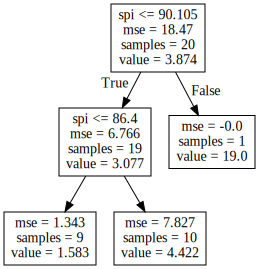

<Figure size 216x144 with 0 Axes>

In [10]:
plt.figure(figsize=(3,2))
graphviz.Source(tree.export_graphviz(dtree, feature_names=X.columns))
#graphviz.Source(tree.plot_tree(dtree))

In [11]:
add_prediction(new_X, dtree.predict(new_X))

,ssm,gini,ppp,spi,nat_p,pred
zero,0,0,0,0,0,1.583084
worst,0,0,0,0,100,1.583084
best,1,0,100000,100,0,19.000000
country1,1,0.56,40000,67,66,1.583084
country2,0,0.28,55000,78,34,1.583084


## Model 3: Random forests

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0,n_estimators=100)
rf.fit(train_X,train_y)
rf_pred = rf.predict(test_X)

print(mean_squared_error(rf_pred, test_y))

add_prediction(df.loc[test_X.index],rf_pred)

12.423931578575234


,ssm,gini,ppp,spi,nat_p,max_ev_p,pred
country,,,,,,,
Croatia,0.0,32.2,25264.0,79.60,5.80,0.107844,1.269545
China,0.0,38.6,16807.0,64.57,50.00,4.640000,1.308890
Netherlands,1.0,28.6,52941.0,89.34,14.88,11.129258,2.853711
Romania,0.0,27.5,25841.0,74.51,4.30,0.581767,1.666816
Estonia,0.0,34.6,31638.0,83.49,17.98,4.524769,2.442214
Latvia,0.0,35.1,27598.0,79.25,17.10,1.328374,1.879068
United Kingdom,1.0,34.1,43877.0,88.74,1.80,4.568673,4.100303


## Model 4: Linear Regression

Some of the features are strongly correlated (e.g. GDP per capita and social progress index), which causes problems with linear regression models. Therefore, we will only train the model on a subset of features.

In [13]:
reg = linear_model.LinearRegression()

columns = ['ssm','ppp','nat_p']

train_X_reg = train_X[columns].copy()
test_X_reg = test_X[columns].copy()
new_X_reg = new_X[columns].copy()

reg.fit(train_X_reg,train_y)
reg_pred = reg.predict(test_X_reg)

print("MSE:", mean_squared_error(test_y,reg_pred))

print(reg.coef_,train_X_reg.columns)

add_prediction(df.loc[test_X.index], reg.predict(test_X_reg))

MSE: 11.45747611389879
[ 8.98077254e-01  7.49162043e-05 -5.89222336e-02] Index(['ssm', 'ppp', 'nat_p'], dtype='object')


,ssm,gini,ppp,spi,nat_p,max_ev_p,pred
country,,,,,,,
Croatia,0.0,32.2,25264.0,79.60,5.80,0.107844,2.683866
China,0.0,38.6,16807.0,64.57,50.00,4.640000,-0.554063
Netherlands,1.0,28.6,52941.0,89.34,14.88,11.129258,5.120385
Romania,0.0,27.5,25841.0,74.51,4.30,0.581767,2.815476
Estonia,0.0,34.6,31638.0,83.49,17.98,4.524769,2.443709
Latvia,0.0,35.1,27598.0,79.25,17.10,1.328374,2.192899
United Kingdom,1.0,34.1,43877.0,88.74,1.80,4.568673,5.212047


In [14]:
add_prediction(new_X_reg, reg.predict(new_X_reg))

,ssm,ppp,nat_p,pred
zero,0,0,0,1.132932
worst,0,0,100,-4.759292
best,1,100000,0,9.522629
country1,1,40000,66,1.138790
country2,0,55000,34,3.249967


# Choice of model

## Model 1: KNN

* The sample size is too small for KNN to work well
* For example, the predicted share should not drop after a certain GDP per capita has been reached merely because there is a country with a high GDP per capita that has a low EV market share

## Model 2,3: Decision trees

* The relationships between the predictor and target variables are roughly linear and don't depend on other predictor variables
* e.g. a higher gini index means a lower market share, higher GDP per capita is correlated with a higher market share
* Therefore, decision trees, which model non-linear relationships, are not a natural choice here

## Model 4: Regression (Winner!)

A very simple model with many upsides:
* It is competitive when it comes to MSE (it has 11, while random forests have 12)
* Its predictions are **consistent with our intuition** (e.g. higher GDP per capita always means higher EV market share) and, thus, are **easily understandable**!
* Since it is linear, **it is very robust** (e.g. the predicted value does not suddenly drop after a certain level of GDP per capita has been reached)
* **Its predictions on unlabeled data make sense!** (Which is the end goal!)

It still has some minor problems:
* Sometimes produces negative values (e.g. see the 'worst' unlabeled sample above)
* It is bad at predicting non-European countries (e.g. it predicts China to have a negative EV share, even though it is one of the leaders in the industry!)
    * But this is because it was trained mostly on European countries!
* Cannot model complex relationships by nature

However, the upsides prevail (especially the last point) and for these reasons, **we will pick the regression model!**